In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from agents import agents
from utils.env_utils import make_gc_env_and_datasets
from utils.flax_utils import restore_agent
from utils.datasets import Dataset, GCDataset, HGCDataset
from agents.cfgrl import get_config

/home/jennifer/miniconda3/envs/fql/lib/python3.10/site-packages/Cython/Distutils/old_build_ext.py:15: DeprecationWarning: dep_util is Deprecated. Use functions from setuptools instead.
  from distutils.dep_util import newer, newer_group
/home/jennifer/miniconda3/envs/fql/lib/python3.10/site-packages/Cython/Distutils/old_build_ext.py:15: DeprecationWarning: dep_util is Deprecated. Use functions from setuptools instead.
  from distutils.dep_util import newer, newer_group
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


In [4]:
np.random.seed(0)
env, train_dataset, val_dataset = make_gc_env_and_datasets('antmaze-medium-navigate-singletask-v0', frame_stack=None)

In [5]:
agent_class = agents['cfgrl']
cfgrl_config = get_config()
dataset_class = eval(cfgrl_config['dataset_class'])

In [6]:
train_dataset = dataset_class(Dataset.create(**train_dataset), cfgrl_config)
example_batch = train_dataset.sample(1)

In [7]:
agent_copy = agent_class.create(
    0,
    example_batch,
    cfgrl_config
)
agent = restore_agent(agent_copy, 'exp/cfgrl/Debug/sd000_20250610_172218', 1000000)

Restored from exp/cfgrl/Debug/sd000_20250610_172218/params_1000000.pkl


In [8]:
from notebooks.utils import all_cells
from notebooks.utils import rollout, plot_axes, get_goals_list
from utils.evaluation import supply_rng
import jax
from notebooks.utils import rollout_fn

all_cells = all_cells(env)

100%|██████████| 300/300 [00:01<00:00, 238.59it/s]


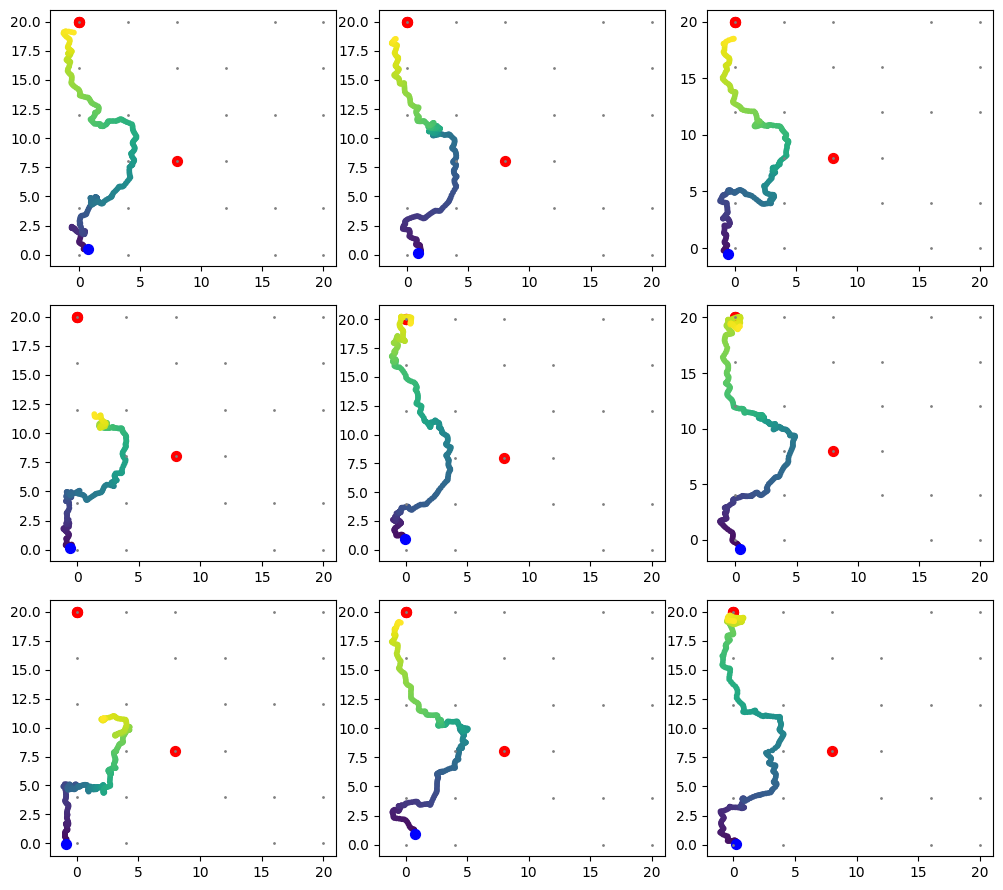

In [21]:
# goal = [[8, 8], [20,0], [20,0], [20,0], [20,0], [20,0]]
goal = [[8, 8], [0, 20], [0, 20], [0, 20]]
goal = get_goals_list(env, goal)

num_rollouts = 3
num_rows = 3
trajs = []
agent_fn = supply_rng(agent.sample_actions, rng=jax.random.PRNGKey(0))
for _ in range(num_rollouts * num_rows):
    traj = rollout_fn(env, goal, agent_fn, num_steps=300, temperature=0.2)
    trajs.append(traj['traj'])

fig, ax = plt.subplots(num_rows, num_rollouts, figsize=(10, num_rows * 3))

for j, traj in enumerate(trajs):
    plot_axes(ax[j // num_rollouts, j % num_rollouts], traj, all_cells=all_cells, goals=goal)
    # ax[i, j].set_title(f'Agent {k}')

plt.tight_layout()
plt.show()

In [13]:
goal[:, :2]

array([[ 8.,  8.],
       [20., 20.],
       [20., 20.],
       [20., 20.],
       [20., 20.],
       [20., 20.]])